In [1]:
%cd ..

/home/nikita/edu/ai-masters/nla1/project


In [2]:
from copy import deepcopy

import torch
from torch import nn
from torch.nn import functional as F
from conv_cp import CPConv2d

In [3]:
from torchmetrics.functional import accuracy
from torchvision.models import resnet18

model = resnet18(pretrained=True)

/home/nikita/edu/ai-masters/nla1/project/.conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nikita/edu/ai-masters/nla1/project/.conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
def get_parameter_count(model):
    return sum(p.numel() for p in model.parameters())
    
def max_rank(layer, step=1):
    sum_shape, dot_shape = 0, 1
    shape_ = layer.weight.shape
    for i in range(len(shape_)):
        sum_shape += shape_[i]
        dot_shape *= shape_[i]
        
    return dot_shape // sum_shape

def get_cp_model(ratio=1):
    cp_model = deepcopy(model)
    for name_1, layer_1 in cp_model.named_children():
        if isinstance(layer_1, nn.Conv2d):
            setattr(cp_model, name_1, CPConv2d(layer_1, int(max_rank(layer_1) * ratio)))
            
        if isinstance(layer_1, nn.Sequential):
            atr_1 = getattr(cp_model, name_1)
            
            for name_2, layer_2 in layer_1.named_children():
                atr_2 = atr_1[int(name_2)]
                
                for name_3, layer_3 in layer_2.named_children():
                    if isinstance(layer_3, nn.Conv2d):
                        setattr(atr_2, name_3, CPConv2d(layer_3, int(max_rank(layer_3) * ratio)))
                            
                atr_1[int(name_2)] = atr_2
            setattr(cp_model, name_1, atr_1)
    return cp_model
    

In [5]:
import glob
import warnings
import sys
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Normalize, Resize, ToTensor

%matplotlib inline
warnings.filterwarnings("ignore")

device = "cuda:0" if torch.cuda.is_available() else "cpu"

dataset = ImageFolder(
    "PetImages",
    transform=Compose(
        [
            Resize((224, 224)),
            ToTensor(),
            Normalize((0.5, 0.5, 0.5), (1, 1, 1)),
        ]
    ),
)
train_set, val_set = torch.utils.data.random_split(
    dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))]
)

train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=256, shuffle=False)

In [6]:
import pytorch_lightning as pl
from torchmetrics.functional import accuracy

def train_epoch(
    model,
    data_loader,
    optimizer,
    return_losses=False,
    device="cuda:0",
):
    model = model.train()
    total_loss = 0
    num_batches = 0
    all_losses = []
    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for batch in data_loader:
            # move Batch to GPU
            batch = [x.to(device=device) for x in batch]
            loss = model(*batch)
            # update weights
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # update description for tqdm
            accuracy = model.get_accuracy()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            num_batches += 1
            all_losses.append(loss.detach().item())
    acc = model.get_accuracy(reset=True)
    metrics = {"loss": total_loss / num_batches, "accuracy": acc}
    if return_losses:
        return metrics, all_losses
    else:
        return metrics


def validate(model, data_loader, device="cuda:0"):
    model = model.eval()
    total_loss = 0
    num_batches = 0
    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for batch in data_loader:
            batch = [x.to(device=device) for x in batch]
            loss = model(*batch)
            accuracy = model.get_accuracy()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            num_batches += 1
    acc = model.get_accuracy(reset=True)
    metrics = {"loss": total_loss / num_batches, "accuracy": acc}
    return metrics

class CatsVSDogsResnet(pl.LightningModule):
    def __init__(self, cp: bool = False, ratio = 1) -> None:
        super().__init__()
        self.cp = cp

        if cp:
            self.model = get_cp_model(ratio)
        else:
            self.model = resnet18(pretrained=True)
            
        self.model.fc = nn.Identity()
        self.classifier = nn.Linear(512, 2)
        self.optimizer = torch.optim.Adam(self.classifier.parameters())

        self.loss = nn.CrossEntropyLoss()

    def forward(self, x) -> torch.Tensor:
        with torch.no_grad():
            features = self.model(x)
        preds = self.classifier(features)
        return preds

    def configure_optimizers(self):
        return self.optimizer

    def training_step(self, train_batch, batch_idx) -> torch.Tensor:
        images, target = train_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx) -> None:
        images, target = val_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        acc = accuracy(torch.argmax(preds, dim=-1).long(), target.long(), task = 'binary')
        self.log("val_loss", loss, prog_bar=True)
        self.log("accuracy", acc, prog_bar=True)

In [7]:
import time
from pytorch_lightning.loggers import CSVLogger



p_list = [0.01, 0.03, 0.05, 0.1, 0.2, 0.4, 0.7, 0.9]
cp_models = []
times = []
logs = []
n_params = []
for p in p_list:
    cats_vs_dogs_pretrained = CatsVSDogsResnet(cp=True, ratio=p)
    logger = CSVLogger("logs/", name=f"model_p_{p}")
    start = time.time()
    trainer = pl.Trainer(accelerator="auto", max_epochs=1, logger=logger)
    trainer.fit(cats_vs_dogs_pretrained, train_dataloader, val_dataloader)
    end = time.time()
    times.append(end-start)
    logs.append(trainer.logged_metrics)
    cp_models.append(deepcopy(cats_vs_dogs_pretrained))
    n_params.append(get_parameter_count(cats_vs_dogs_pretrained))
    

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | model      | ResNet           | 286 K  | train
1 | classifier | Linear           | 1.0 K  | train
2 | loss       | CrossEntropyLoss | 0      | train
--------------------------------------------------------
287 K     Trainable params
0         Non-trainable params
287 K     Total params
1.151     Total estimated model params size (MB)
155       Modules 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | model      | ResNet           | 507 K  | train
1 | classifier | Linear           | 1.0 K  | train
2 | loss       | CrossEntropyLoss | 0      | train
--------------------------------------------------------
508 K     Trainable params
0         Non-trainable params
508 K     Total params
2.033     Total estimated model params size (MB)
155       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | model      | ResNet           | 727 K  | train
1 | classifier | Linear           | 1.0 K  | train
2 | loss       | CrossEntropyLoss | 0      | train
--------------------------------------------------------
728 K     Trainable params
0         Non-trainable params
728 K     Total params
2.913     Total estimated model params size (MB)
155       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | model      | ResNet           | 1.3 M  | train
1 | classifier | Linear           | 1.0 K  | train
2 | loss       | CrossEntropyLoss | 0      | train
--------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.118     Total estimated model params size (MB)
155       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | model      | ResNet           | 2.4 M  | train
1 | classifier | Linear           | 1.0 K  | train
2 | loss       | CrossEntropyLoss | 0      | train
--------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.515     Total estimated model params size (MB)
155       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | model      | ResNet           | 4.6 M  | train
1 | classifier | Linear           | 1.0 K  | train
2 | loss       | CrossEntropyLoss | 0      | train
--------------------------------------------------------
4.6 M     Trainable params
0         Non-trainable params
4.6 M     Total params
18.309    Total estimated model params size (MB)
155       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.10 GiB. GPU 0 has a total capacity of 3.81 GiB of which 132.81 MiB is free. Process 464391 has 102.00 MiB memory in use. Including non-PyTorch memory, this process has 3.57 GiB memory in use. Of the allocated memory 2.37 GiB is allocated by PyTorch, and 1.10 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
acc_list = list(map(lambda x: float(x['accuracy']), logs))

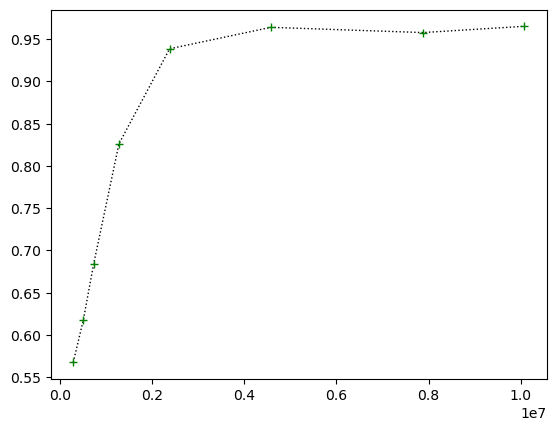

In [ ]:
import matplotlib.pyplot as plt

plt.plot(n_params, acc_list, 'k-', linestyle = ":", lw=1)
plt.plot(n_params, acc_list, 'b+', c='g')

In [ ]:
model_temp = deepcopy(model)
layer_params = []
for name_1, layer_1 in model_temp.named_children():
    if isinstance(layer_1, nn.Conv2d):
        layer_params.append(get_parameter_count(layer_1))
        
    if isinstance(layer_1, nn.Sequential):
        
        for name_2, layer_2 in layer_1.named_children():
            
            for name_3, layer_3 in layer_2.named_children():
                if isinstance(layer_3, nn.Conv2d):
                    layer_params.append(get_parameter_count(layer_3))

In [ ]:
def get_cp_model_small(ratio=1):
    ratio_list = [0.9] * 9 + [ratio] * 8
    t = 0
    cp_model = deepcopy(model)
    for name_1, layer_1 in cp_model.named_children():
        if isinstance(layer_1, nn.Conv2d):
            setattr(cp_model, name_1, CPConv2d(layer_1, int(max_rank(layer_1) * ratio_list[t])))
            t += 1
            
        if isinstance(layer_1, nn.Sequential):
            atr_1 = getattr(cp_model, name_1)
            
            for name_2, layer_2 in layer_1.named_children():
                atr_2 = atr_1[int(name_2)]
                
                for name_3, layer_3 in layer_2.named_children():
                    if isinstance(layer_3, nn.Conv2d):
                        setattr(atr_2, name_3, CPConv2d(layer_3, int(max_rank(layer_3) * ratio_list[t])))
                        t += 1
                            
                atr_1[int(name_2)] = atr_2
            setattr(cp_model, name_1, atr_1)
    return cp_model
    
class CatsVSDogsResnetSmall(pl.LightningModule):
    def __init__(self, cp: bool = False, ratio = 1) -> None:
        super().__init__()
        self.cp = cp

        if cp:
            self.model = get_cp_model_small(ratio)
        else:
            self.model = resnet18(pretrained=True)
            
        self.model.fc = nn.Identity()
        self.classifier = nn.Linear(512, 2)
        self.optimizer = torch.optim.Adam(self.classifier.parameters())

        self.loss = nn.CrossEntropyLoss()

    def forward(self, x) -> torch.Tensor:
        with torch.no_grad():
            features = self.model(x)
        preds = self.classifier(features)
        return preds

    def configure_optimizers(self):
        return self.optimizer

    def training_step(self, train_batch, batch_idx) -> torch.Tensor:
        images, target = train_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx) -> None:
        images, target = val_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        acc = accuracy(torch.argmax(preds, dim=-1).long(), target.long(), task = 'binary')
        self.log("val_loss", loss, prog_bar=True)
        self.log("accuracy", acc, prog_bar=True)

In [ ]:
p_list = [0.01, 0.03, 0.05, 0.1, 0.2, 0.4, 0.7]
times_new = []
logs_new = []
n_params_new = []
for p in p_list:
    cats_vs_dogs_pretrained = CatsVSDogsResnetSmall(cp=True, ratio=p)
    start = time.time()
    trainer = pl.Trainer(accelerator="auto", max_epochs=1, logger=logger)
    trainer.fit(cats_vs_dogs_pretrained, train_dataloader, val_dataloader)
    end = time.time()
    times_new.append(end-start)
    logs_new.append(trainer.logged_metrics)
    n_params_new.append(get_parameter_count(cats_vs_dogs_pretrained))

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | model      | ResNet           | 884 K  | train
1 | classifier | Linear           | 1.0 K  | train
2 | loss       | CrossEntropyLoss | 0      | train
--------------------------------------------------------
885 K     Trainable params
0         Non-trainable params
885 K     Total params
3.544     Total estimated model params size (MB)
155       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | model      | ResNet           | 1.1 M  | train
1 | classifier | Linear           | 1.0 K  | train
2 | loss       | CrossEntropyLoss | 0      | train
--------------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.372     Total estimated model params size (MB)
155       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | model      | ResNet           | 1.3 M  | train
1 | classifier | Linear           | 1.0 K  | train
2 | loss       | CrossEntropyLoss | 0      | train
--------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.196     Total estimated model params size (MB)
155       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | model      | ResNet           | 1.8 M  | train
1 | classifier | Linear           | 1.0 K  | train
2 | loss       | CrossEntropyLoss | 0      | train
--------------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.267     Total estimated model params size (MB)
155       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | model      | ResNet           | 2.8 M  | train
1 | classifier | Linear           | 1.0 K  | train
2 | loss       | CrossEntropyLoss | 0      | train
--------------------------------------------------------
2.8 M     Trainable params
0         Non-trainable params
2.8 M     Total params
11.395    Total estimated model params size (MB)
155       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | model      | ResNet           | 4.9 M  | train
1 | classifier | Linear           | 1.0 K  | train
2 | loss       | CrossEntropyLoss | 0      | train
--------------------------------------------------------
4.9 M     Trainable params
0         Non-trainable params
4.9 M     Total params
19.653    Total estimated model params size (MB)
155       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | model      | ResNet           | 8.0 M  | train
1 | classifier | Linear           | 1.0 K  | train
2 | loss       | CrossEntropyLoss | 0      | train
--------------------------------------------------------
8.0 M     Trainable params
0         Non-trainable params
8.0 M     Total params
32.033    Total estimated model params size (MB)
155       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


In [ ]:
new_acc_list = list(map(lambda x: float(x['accuracy']), logs_new))

In [ ]:
cats_vs_dogs_pretrained = CatsVSDogsResnetSmall(cp=False)
start = time.time()
trainer = pl.Trainer(accelerator="auto", max_epochs=1, logger=logger)
trainer.fit(cats_vs_dogs_pretrained, train_dataloader, val_dataloader)
end = time.time()
times.append(end-start)
logs.append(trainer.logged_metrics)
acc_list.append(float(logs[-1]['accuracy']))
n_params.append(get_parameter_count(cats_vs_dogs_pretrained))

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | model      | ResNet           | 11.2 M | train
1 | classifier | Linear           | 1.0 K  | train
2 | loss       | CrossEntropyLoss | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)
70        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


TypeError: list indices must be integers or slices, not str

In [ ]:
n_params = list(map(lambda x: round(x/1e6, 2), n_params))
n_params_new = list(map(lambda x: round(x/1e6, 2), n_params_new))

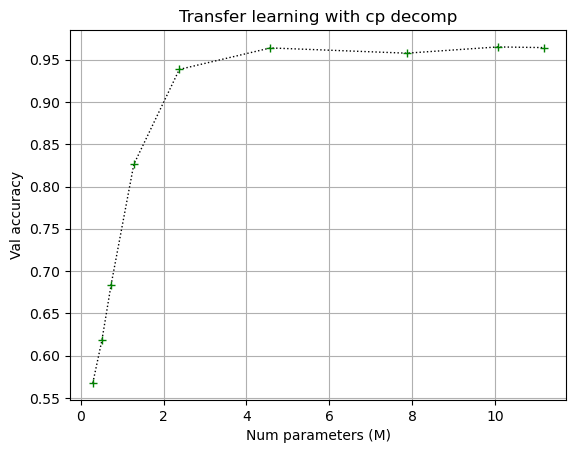

In [ ]:
plt.plot(n_params, acc_list, 'k-', linestyle = ":", lw=1)
plt.plot(n_params, acc_list, 'b+', c='g')

plt.grid()
plt.xlabel('Num parameters (M)')
plt.ylabel('Val accuracy')
plt.title('Transfer learning with cp decomp')
plt.savefig('def_approach.jpg', format='jpeg')

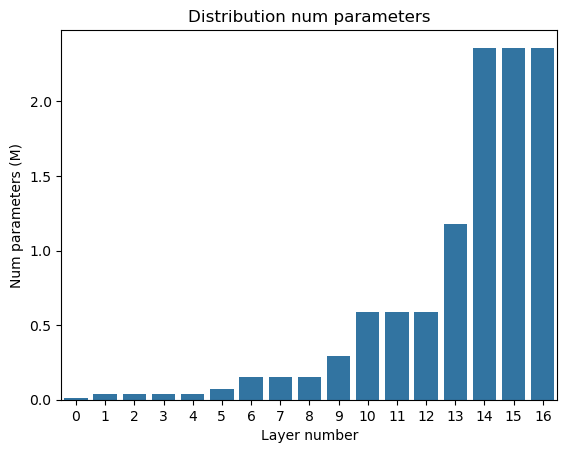

In [ ]:
import seaborn as sns
sns.barplot(list(map(lambda x: round(x/1e6, 2), layer_params)))
plt.xlabel('Layer number')
plt.ylabel('Num parameters (M)')
plt.title('Distribution num parameters')
plt.savefig('distribution_num_def.jpg', format='jpeg')

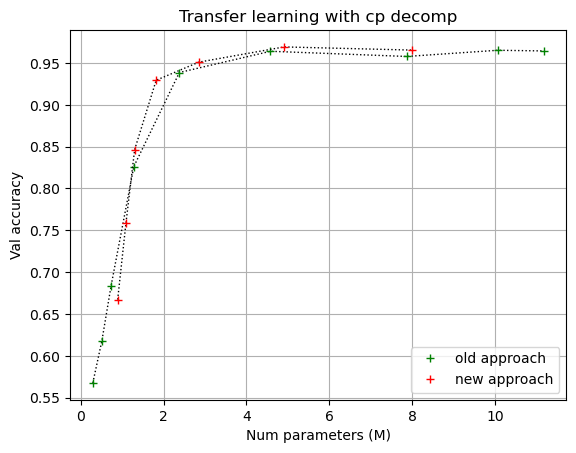

In [ ]:
plt.plot(n_params, acc_list, 'k-', linestyle = ":", lw=1)
plt.plot(n_params, acc_list, 'b+', c='g', label='old approach')

plt.plot(n_params_new, new_acc_list, 'k-', linestyle = ":", lw=1)
plt.plot(n_params_new, new_acc_list, 'b+', c='r', label='new approach')

plt.grid()
plt.xlabel('Num parameters (M)')
plt.ylabel('Val accuracy')
plt.title('Transfer learning with cp decomp')
plt.legend()
plt.savefig('new_approach.jpg', format='jpeg')